# Using Transition Matrix Methods under IndShockConsumerType

By William Du

This Jupyter Notebook demonstrates how to non-stochastically simulate an economy with transition matrices with functions under the IndShockConsumerType.

The three key functions to non stochastically simulate are:

##### define_distribution_grid
- computes the grid of normalized market resources and the grid permanent income storing each as attributes of self.

###### calc_transition_matrix 
- computes transition matrix (matrices), a grid of consumption policies, and a grid asset policies stored as attributes of self. If the problem has a finite horizon, this function stores lists of transition matrices, consumption policies and asset policies grid for each period as attributes of self.

##### calc_ergodic_dist 
- computes the ergodic distribution stored as attributes. The distribution is stored as a vector (self.vec_erg_dstn) and as a grid (self.erg_dstn)



## Set up Computational Environment

In [1]:
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType
import time
from copy import copy, deepcopy
import numpy as np
import matplotlib.pyplot as plt


C:\Users\wdu\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\wdu\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\wdu\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Set up the Dictionary

In [2]:

Dict={
    # Parameters shared with the perfect foresight model
    "CRRA":2,                              # Coefficient of relative risk aversion
    "Rfree": 1.05**.25,                    # Interest factor on assets
    "DiscFac": 0.97,                       # Intertemporal discount factor
    "LivPrb" : [.99375],                   # Survival probability
    "PermGroFac" :[1.00],                  # Permanent income growth factor

    # Parameters that specify the income distribution over the lifecycle
   
    "PermShkStd" :  [.05],                 # Standard deviation of log permanent shocks to income
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [.3],                   # Standard deviation of log transitory shocks to income
    "TranShkCount" : 5,                    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.05,                     # Probability of unemployment while working
    "IncUnemp" :  .2,                      # Unemployment benefits replacement rate
    "UnempPrbRet" : 0.0005,                # Probability of "unemployment" while retired
    "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
    "T_retire" : 0,                        # Period of retirement (0 --> no retirement)
    "tax_rate" : .3,                       # Flat income tax rate (legacy parameter, will be removed in future)

    # Parameters for constructing the "assets above minimum" grid
    "aXtraMin" : 0.001,                    # Minimum end-of-period "assets above minimum" value
    "aXtraMax" : 20,                       # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 48,                     # Number of points in the base grid of "assets above minimum"
    "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraExtra" : [None],                 # Additional values to add to aXtraGrid

    # A few other parameters
    "BoroCnstArt" : 0.0,                   # Artificial borrowing constraint; imposed minimum level of end-of period assets
    "vFuncBool" : False,                   # Whether to calculate the value function during solution
    "CubicBool" : False,                   # Preference shocks currently only compatible with linear cFunc
    "T_cycle" : 1,                         # Number of periods in the cycle for this agent type

    # Parameters only used in simulation
    "AgentCount" : 10000,                  # Number of agents of this type
    "T_sim" : 2000,                        # Number of periods to simulate
    "aNrmInitMean" : np.log(1.6)-(.5**2)/2,# Mean of log initial assets
    "aNrmInitStd"  : .5,                   # Standard deviation of log initial assets
    "pLvlInitMean" : 0.0,                  # Mean of log initial permanent income
    "pLvlInitStd"  : 0.0,                  # Standard deviation of log initial permanent income
    "PermGroFacAgg" : 1.0,                 # Aggregate permanent income growth factor
    "T_age" : None,                        # Age after which simulated agents are automatically killed
    
     }


## Create an Instance of IndShockConsumerType and Solve

In [3]:
example1 = IndShockConsumerType(**Dict,verbose = False)
example1.cycles = 0
example1.solve()


# Simulation: Transition Matrix vs Monte Carlo

This section compares monte carlo methods against the transition matrix approach in computing aggregate consumption and aggregate assets.

## Method 1: Monte Carlo 

In [4]:
#Simulate
example1.initialize_sim()
example1.simulate()

#Compute Aggregate Consumption and Aggregate Assets
Simulated_Consumption = np.mean((example1.state_now['mNrm'] - example1.state_now['aNrm'])*example1.state_now['pLvl'])
Simulated_Assets = np.mean(example1.state_now['aNrm']*example1.state_now['pLvl'])

## Method 2: Transition Matrices

In [5]:
example1.define_distribution_grid()
p = example1.dist_pGrid # Grid of permanent income levels

example1.calc_transition_matrix()
c = example1.cPol_Grid #Consumption Policy Grid
asset = example1.aPol_Grid # Asset Policy Grid

example1.calc_ergodic_dist()
vecDstn = example1.vec_erg_dstn # Distribution of market resources and permanent income as a vector (m*p)x1 vector where 
# m is the number of market resource gridpoints and p is the number of permanent income gridpoints


In [6]:
#Compute Aggregate Consumption and Aggregate Assets
gridc = np.zeros((len(c),len(p)))
grida = np.zeros((len(asset),len(p)))

for j in range(len(p)):
    gridc[:,j] = p[j]*c
    grida[:,j] = p[j]*asset
    
AggC = np.dot(gridc.flatten(),vecDstn) #Aggregate Consumption
AggA = np.dot(grida.flatten() ,vecDstn) #Aggregate Assets

### Comparing Outputs of Both Methods

In [7]:
print('TranMatrix Assets = ' + str(AggA[0]))
print('Simulated Assets = ' +str(Simulated_Assets))

print('TranMatrix Consumption = ' + str(AggC[0]))
print('Simulated Consumption = ' +str(Simulated_Consumption))

TranMatrix Assets = 1.1484372640738985
Simulated Assets = 1.1878906213808793
TranMatrix Consumption = 1.0059681831619494
Simulated Consumption = 1.0076918586002666


### Comparing Distributions of Normalized Market Resources

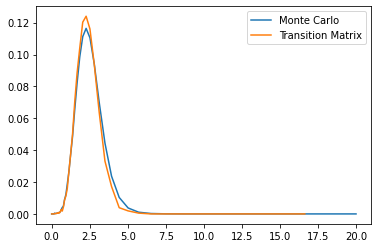

In [8]:
mdstn = np.zeros(48) 

for i in range(48):
    mdstn[i] = np.sum(example1.erg_dstn[i]) #distribution of normalized market resources

h = np.histogram(example1.state_now['mNrm'],bins=example1.dist_mGrid)[0]/np.sum(np.histogram(example1.state_now['mNrm'],bins=example1.dist_mGrid)[0]) #Form Monte Carlo wealth data and put into histogram/bins
plt.plot(example1.dist_mGrid,mdstn,label='Monte Carlo') #distribution using Monte Carlo
plt.plot(example1.dist_mGrid[:-1],h , label = 'Transition Matrix') # distribution using transition matrix method
plt.legend()
plt.show()

# Calculating the Path of Consumption given an MIT shock

This section details an experiment to exhibit how to the transition matrix method can be utilized to compute the paths of aggregate consumption and aggregate assets given a pertubation in a variable for one period. In particular, in this experiment, agents anticipates a change in the interest rate during period 10 and plots the simulated paths of aggregate consumption and aggregate assets.

### Compute Steady State Distribution

In [9]:
ss = IndShockConsumerType(**Dict) 
ss.cycles = 0
ss.solve()

ss.define_distribution_grid()
p = ss.dist_pGrid # Grid of permanent income 

ss.calc_transition_matrix()
c = ss.cPol_Grid # Normalized Consumption Policy grid
a = ss.aPol_Grid #Normalized Asset Policy grid

ss.calc_ergodic_dist()
vecDstn = ss.vec_erg_dstn # Steady State Distribution as a vector

GPFRaw                 = 0.990911 
GPFNrm                 = 0.993135 
GPFAggLivPrb           = 0.984718 
Thorn = APF            = 0.990911 
PermGroFacAdj          = 0.997760 
uInvEpShkuInv          = 0.997760 
VAF                    = 0.961779 
WRPF                   = 0.218203 
DiscFacGPFNrmMax       = 0.983457 
DiscFacGPFAggLivPrbMax = 0.994090 


## Simulating With Harmenberg (2021) Method

Harmenberg (2021) method may also be implemented when simulating with transition matrices. 

For more information on Harmenberg's Method to dramatically improve simulation times see https://github.com/econ-ark/DemARK/blob/master/notebooks/Harmenberg-Aggregation.ipynb 

In [10]:
# Change the income process to use Neutral Measure
ss.neutral_measure = True 
ss.update_income_process()

In [11]:
# Set up grid and calculate transition Matrices
ss.define_distribution_grid()
ss.calc_transition_matrix()

c = ss.cPol_Grid # Normalized Consumption Policy grid
a = ss.aPol_Grid #Normalized Asset Policy grid

ss.calc_ergodic_dist() #Calculate ergodic distribution
vecDstn_fast = ss.vec_erg_dstn #Distribution as a vector


### Solve an Agent who Anticipates a Change in the Interest Rate

In [12]:
# We will solve a finite horizon problem that begins at the steady state computed above. 
# Therefore parameters must be specified as lists, each item's index indicating the period of the horizon.

params = deepcopy(Dict)
params['T_cycle']= 20
params['LivPrb']= params['T_cycle']*[ss.LivPrb[0]]
params['PermGroFac']=params['T_cycle']*[1]
params['PermShkStd'] = params['T_cycle']*[ss.PermShkStd[0]]
params['TranShkStd']= params['T_cycle']*[ss.TranShkStd[0]]
params['Rfree'] = params['T_cycle']*[ss.Rfree]

FinHorizonAgent = IndShockConsumerType(**params)
FinHorizonAgent.cycles = 1
FinHorizonAgent.del_from_time_inv('Rfree') #delete Rfree from time invariant list since it varies overtime
FinHorizonAgent.add_to_time_vary('Rfree')
FinHorizonAgent.IncShkDstn = params['T_cycle']*ss.IncShkDstn
FinHorizonAgent.cFunc_terminal_ = deepcopy(ss.solution[0].cFunc) # Set Terminal Solution as Steady State Consumption Function
FinHorizonAgent.track_vars = ['cNrm','pLvl'] 


### Implement perturbation in interest rate

In [13]:
dx=.01 # Change in the Interest Rate
i = 10 # Period in which the change in the interest rate occurs
FinHorizonAgent.Rfree = (i)*[ss.Rfree] + [ss.Rfree + dx] + (params['T_cycle'] - i -1 )*[ss.Rfree] # Sequence of interest rates the agent faces


### Solve Agent

In [14]:
FinHorizonAgent.solve()

### Calculate Transition Matrices

In [15]:
start = time.time()
FinHorizonAgent.define_distribution_grid() 
FinHorizonAgent.calc_transition_matrix()
print('seconds past : ' + str(time.time()-start))

FinHorizonAgent.calc_agg_path(init_dstn = vecDstn) #calc_agg_path calculates the paths of aggregate assets and consumption storing each as attributes self.

AggC = FinHorizonAgent.AggC

seconds past : 90.43622612953186


calc_agg_path computes the paths of aggregate consumption and aggregate assets storing each time series as attributes of self given the initial distribution as an argument. This method is called after non stochastic simulation. 

### Calculate Transition matrices with Neutral Measure (Harmenberg 2021)

In [16]:
# Change Income Process to allow permanent income shocks to be drawn from neutral measure
FinHorizonAgent.neutral_measure = True
FinHorizonAgent.update_income_process()

# Calculate Transition Matrices
start = time.time()
FinHorizonAgent.define_distribution_grid() 
FinHorizonAgent.calc_transition_matrix()
print('seconds past : ' + str(time.time()-start))

#Calculate Macro Aggregates given Transition Matrices
FinHorizonAgent.calc_agg_path(init_dstn = vecDstn_fast)

AggC_fast = FinHorizonAgent.AggC

seconds past : 0.939253568649292


Notice the dramatic speed improvement from 93 seconds to 1 second. 

### Path of Aggregate Consumption given an anticipated interest rate shock at $t=10$


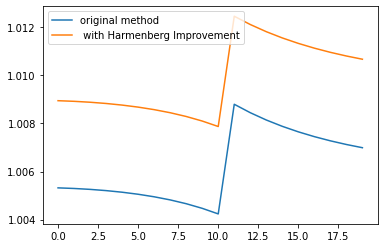

In [17]:
plt.plot(AggC, label = 'original method') #Without Neutral Measure
plt.plot(AggC_fast, label = ' with Harmenberg Improvement') #With Harmenberg Improvement
plt.legend()
plt.show()

The minor difference in consumption paths is due to the fact that the original method's accuracy is limited by the size of the permanent income grid which in this exercise is only 101 points. Harmenberg's method eliminates the permanent income grid completely from the computation of aggregates and is more precise. 